In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re

img_dir = "small_data_2d/original"
mask_dir = "small_data_2d/ground_truth"
# subdirs = ["train", "valid", "test"]

In [2]:
mask_pattern_const = r"SEM_adult_gj_segmentation_WL.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png"
img_pattern_const = r"Dataset8_export_s(\d+)_Y(\d+)_X(\d+).png"
def get_z_y_x(file_name, pattern):
    """ get z, y, x from file name (uses basename of file_name)"""
    file_name = os.path.basename(file_name)
    match = re.match(pattern, file_name)
    if match:
        if len(match.groups()) != 3:
            return None
        z, y, x = match.groups()
        return int(z), int(y), int(x)
    else:
        return None
    
def get_img_by_coords(z, y, x, img_files, img_pattern):
    """ get path of image by z, y, x """
    for i in range(len(img_files)):
        img_file = img_files[i]
        z_, y_, x_ = get_z_y_x(img_file, img_pattern)
        if z == z_ and y == y_ and x == x_:
            return cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    return None

def get_3d_slice(z,y,x, img_files, mask_files, img_pattern, mask_pattern, depth=1, width=512, height=512):
    """ get 3d slice by z, y, x 
    
    -think of the original image as 3d volume, and each slice is a pixel
    -so we want a column of pixels, with the center pixel being the pixel at z, y, x, and sliding up and down along the z axis
    
    Args:
        z: int, z coordinate
        y: int, y coordinate
        x: int, x coordinate
        img_files: list of str, paths to images
        mask_files: list of str, paths to masks
        img_pattern: str, pattern to extract z, y, x from image file name
        mask_pattern: str, pattern to extract z, y, x from mask file name
        depth: int, how many slices to include above and below the center slice
        width: int, width of each slice
        height: int, height of each slice
    """
    img_3d = np.zeros((2*depth+1, width, height))
    mask_3d = np.zeros((2*depth+1, width, height))
    for i in range(-depth, depth+1):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x, img_files, img_pattern)
        mask = get_img_by_coords(z_coord, y, x, mask_files, mask_pattern)
        if img is not None and mask is not None:
            img_3d[i+depth] = img
            mask_3d[i+depth] = mask
    return img_3d, mask_3d

In [3]:
# sort the files by z, y, x (ensure that img and mask files are in the same order)
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)
mask_pattern = r"z(\d+)_y(\d+)_x(\d+).png"
img_pattern = r"z(\d+)_y(\d+)_x(\d+).png"
mask_files.sort(key=lambda x: get_z_y_x(x, mask_pattern))
img_files.sort(key=lambda x: get_z_y_x(x, img_pattern))
img_files = [os.path.join(img_dir, f) for f in img_files]
mask_files = [os.path.join(mask_dir, f) for f in mask_files]
print(img_files[:10])
print(mask_files[:10])

['small_data_2d/original/z200_y7_x17.png', 'small_data_2d/original/z200_y7_x18.png', 'small_data_2d/original/z200_y8_x16.png', 'small_data_2d/original/z200_y8_x17.png', 'small_data_2d/original/z200_y8_x18.png', 'small_data_2d/original/z200_y9_x15.png', 'small_data_2d/original/z200_y9_x16.png', 'small_data_2d/original/z200_y9_x17.png', 'small_data_2d/original/z200_y10_x15.png', 'small_data_2d/original/z200_y10_x16.png']
['small_data_2d/ground_truth/z200_y7_x17.png', 'small_data_2d/ground_truth/z200_y7_x18.png', 'small_data_2d/ground_truth/z200_y8_x16.png', 'small_data_2d/ground_truth/z200_y8_x17.png', 'small_data_2d/ground_truth/z200_y8_x18.png', 'small_data_2d/ground_truth/z200_y9_x15.png', 'small_data_2d/ground_truth/z200_y9_x16.png', 'small_data_2d/ground_truth/z200_y9_x17.png', 'small_data_2d/ground_truth/z200_y10_x15.png', 'small_data_2d/ground_truth/z200_y10_x16.png']


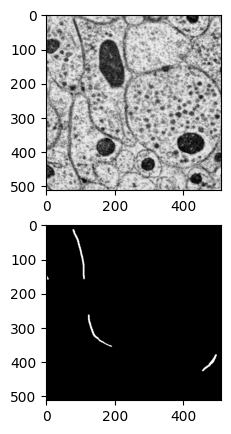

In [4]:
# sanity check: test that image and mask actually match
num = 20
z,y,x= get_z_y_x(img_files[num].split('/')[-1], img_pattern)
tmp_img = get_img_by_coords(z, y, x, img_files, img_pattern)
tmp_mask = get_img_by_coords(z, y, x, mask_files, mask_pattern)
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].imshow(tmp_img, cmap='gray')
ax[1].imshow(tmp_mask, cmap='gray')

(5, 512, 512) (5, 512, 512)


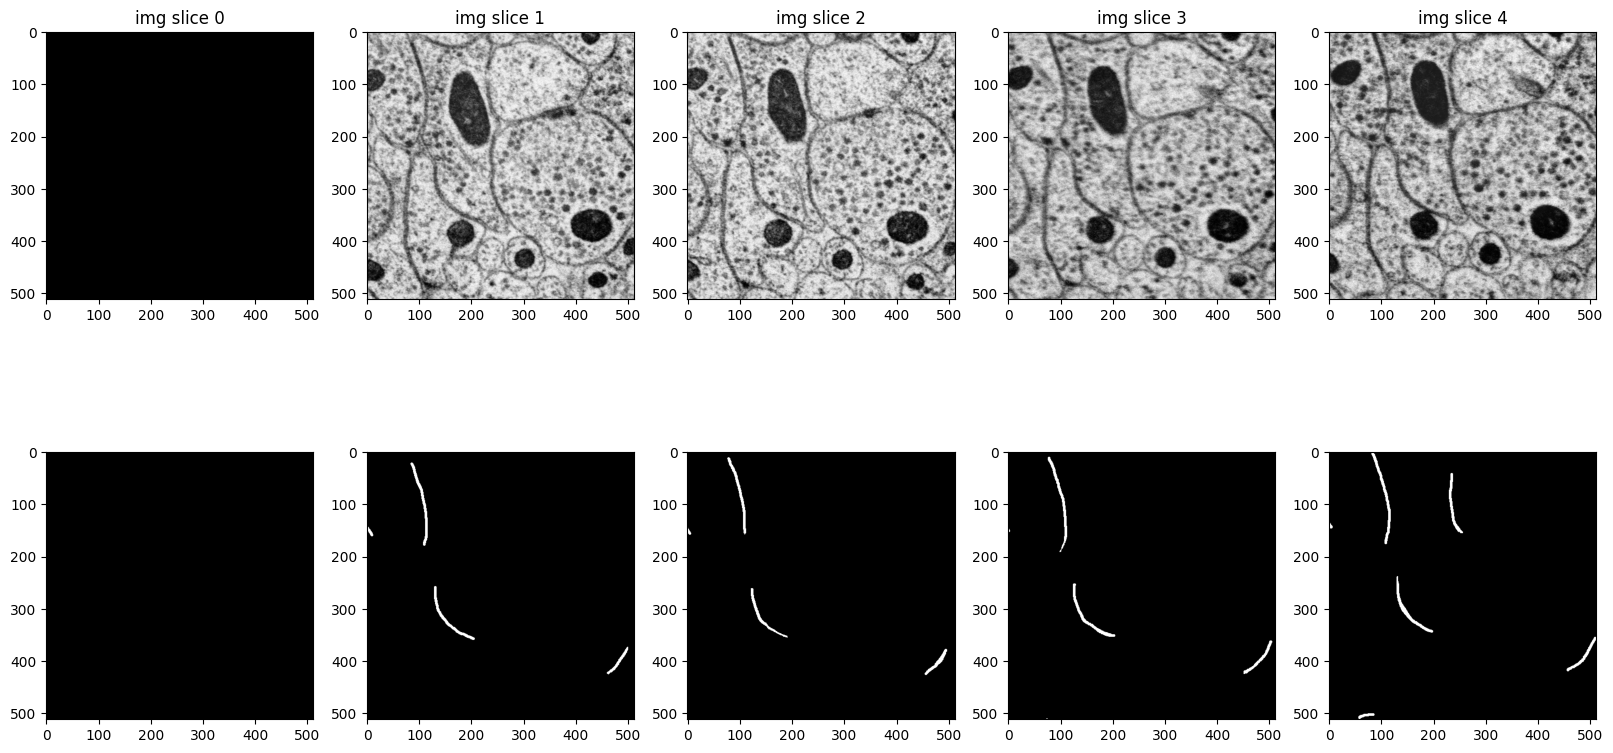

In [5]:
# 3d slice sanity check
depth = 2
img_3d, mask_3d = get_3d_slice(z, y, x, img_files, mask_files, img_pattern, mask_pattern, depth=2)
print(img_3d.shape, mask_3d.shape)
fig, ax = plt.subplots(2, 2*depth+1, figsize=(20, 10))
for i in range(2*depth+1):
    ax[0, i].imshow(img_3d[i], cmap='gray')
    ax[1, i].imshow(mask_3d[i], cmap='gray')
    ax[0, i].set_title(f"img slice {i}")
plt.show()

In [6]:
print(len(img_files), len(mask_files))

243 242


In [7]:
save_dir = "small_data_3d_5"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(os.path.join(save_dir, "original")):
    os.makedirs(os.path.join(save_dir, "original"))
if not os.path.exists(os.path.join(save_dir, "ground_truth")):
    os.makedirs(os.path.join(save_dir, "ground_truth"))

In [8]:
# save 3d slices
import tqdm
depth = 2 # (5, 512, 512)
for i in tqdm.tqdm(range(len(img_files))):
    z, y, x = get_z_y_x(img_files[i], img_pattern)
    img_3d, mask_3d = get_3d_slice(z, y, x, img_files, mask_files, img_pattern, mask_pattern, depth=depth)
    img_3d = img_3d.astype(np.uint8)
    mask_3d = mask_3d.astype(np.uint8)
    if i == 0:
        print(img_3d.shape, mask_3d.shape)
    np.save(os.path.join(save_dir, "original", f"z{z}_y{y}_x{x}.npy"), img_3d)
    np.save(os.path.join(save_dir, "ground_truth", f"z{z}_y{y}_x{x}.npy"), mask_3d)

  1%|          | 2/243 [00:00<00:27,  8.89it/s]

(5, 512, 512) (5, 512, 512)


100%|██████████| 243/243 [00:32<00:00,  7.47it/s]


In [9]:
files = os.listdir(os.path.join(save_dir, "original"))
print(len(files)) # 243 training samples (some may overlap a bit, fine for now)

243


# Train Test Split

In [10]:
data_dir = "small_data_3d_5" # CHANGE ME

# load data
img_dir = os.path.join(data_dir, "original")
mask_dir = os.path.join(data_dir, "ground_truth")
img_paths = os.listdir(img_dir)
mask_paths = os.listdir(mask_dir)
imgs = [np.load(os.path.join(img_dir, img_path)) for img_path in img_paths if img_path.endswith(".npy")]
masks = [np.load(os.path.join(mask_dir, mask_path)) for mask_path in mask_paths if mask_path.endswith(".npy")]

In [11]:
# create subdirectories for train, valid, test
if not os.path.exists(os.path.join(img_dir, "train")):
    os.makedirs(os.path.join(img_dir, "train"))
if not os.path.exists(os.path.join(img_dir, "valid")):
    os.makedirs(os.path.join(img_dir, "valid"))
if not os.path.exists(os.path.join(img_dir, "test")):
    os.makedirs(os.path.join(img_dir, "test"))   
if not os.path.exists(os.path.join(mask_dir, "train")):
    os.makedirs(os.path.join(mask_dir, "train"))
if not os.path.exists(os.path.join(mask_dir, "valid")):
    os.makedirs(os.path.join(mask_dir, "valid"))
if not os.path.exists(os.path.join(mask_dir, "test")):
    os.makedirs(os.path.join(mask_dir, "test"))

In [12]:
# split data into train, valid, test
num_imgs = len(imgs)
indices = np.arange(num_imgs)
np.random.shuffle(indices)
train_indices = indices[:int(0.6*num_imgs)]
valid_indices = indices[int(0.6*num_imgs):int(0.8*num_imgs)]
test_indices = indices[int(0.8*num_imgs):]
imgs = np.array(imgs)
masks = np.array(masks)
print("imgs shape: ", imgs.shape)

imgs shape:  (243, 5, 512, 512)


In [13]:
train_imgs = imgs[train_indices]
valid_imgs = imgs[valid_indices]
test_imgs = imgs[test_indices]

train_masks = masks[train_indices]
valid_masks = masks[valid_indices]
test_masks = masks[test_indices]
print(f"Train: {train_masks.shape}, {train_imgs.shape}") # (num_imgs, 512, 512, 3)
print(f"Valid: {valid_masks.shape}, {valid_imgs.shape}")
print(f"Test: {test_masks.shape}, {test_imgs.shape}")

Train: (145, 5, 512, 512), (145, 5, 512, 512)
Valid: (49, 5, 512, 512), (49, 5, 512, 512)
Test: (49, 5, 512, 512), (49, 5, 512, 512)


In [14]:
# save imgs
for i,img in tqdm.tqdm(enumerate(train_imgs)):
    np.save(os.path.join(img_dir, "train", f"{i}.npy"), train_imgs[i])
    print(f"Saved train {i}")
for i,img in tqdm.tqdm(enumerate(valid_imgs)):
    np.save(os.path.join(img_dir, "valid", f"{i}.npy"), valid_imgs[i])
    print(f"Saved valid {i}")
for i,img in tqdm.tqdm(enumerate(test_imgs)):
    np.save(os.path.join(img_dir, "test", f"{i}.npy"), test_imgs[i])
    print(f"Saved test {i}")

# save masks
for i,mask in tqdm.tqdm(enumerate(train_masks)):
    np.save(os.path.join(mask_dir, "train", f"{i}.npy"), train_masks[i])
    print(f"Saved train {i}")
for i,mask in tqdm.tqdm(enumerate(valid_masks)):
    np.save(os.path.join(mask_dir, "valid", f"{i}.npy"), valid_masks[i])
    print(f"Saved valid {i}")
for i,mask in tqdm.tqdm(enumerate(test_masks)):
    np.save(os.path.join(mask_dir, "test", f"{i}.npy"), test_masks[i])
    print(f"Saved test {i}")

print("Done")

12it [00:00, 54.98it/s]

Saved train 0
Saved train 1
Saved train 2
Saved train 3
Saved train 4
Saved train 5
Saved train 6
Saved train 7
Saved train 8
Saved train 9
Saved train 10
Saved train 11


18it [00:00, 50.67it/s]

Saved train 12
Saved train 13
Saved train 14
Saved train 15
Saved train 16
Saved train 17
Saved train 18
Saved train 19
Saved train 20


30it [00:00, 47.36it/s]

Saved train 21
Saved train 22
Saved train 23
Saved train 24
Saved train 25
Saved train 26
Saved train 27
Saved train 28
Saved train 29
Saved train 30
Saved train 31


44it [00:00, 55.59it/s]

Saved train 32
Saved train 33
Saved train 34
Saved train 35
Saved train 36
Saved train 37
Saved train 38
Saved train 39
Saved train 40
Saved train 41
Saved train 42
Saved train 43
Saved train 44


51it [00:00, 56.80it/s]

Saved train 45
Saved train 46
Saved train 47
Saved train 48
Saved train 49
Saved train 50
Saved train 51
Saved train 52
Saved train 53
Saved train 54
Saved train 55


63it [00:01, 46.86it/s]

Saved train 56
Saved train 57
Saved train 58
Saved train 59
Saved train 60
Saved train 61
Saved train 62
Saved train 63


73it [00:01, 45.37it/s]

Saved train 64
Saved train 65
Saved train 66
Saved train 67
Saved train 68
Saved train 69
Saved train 70
Saved train 71
Saved train 72


85it [00:01, 51.29it/s]

Saved train 73
Saved train 74
Saved train 75
Saved train 76
Saved train 77
Saved train 78
Saved train 79
Saved train 80
Saved train 81
Saved train 82
Saved train 83
Saved train 84


98it [00:01, 55.57it/s]

Saved train 85
Saved train 86
Saved train 87
Saved train 88
Saved train 89
Saved train 90
Saved train 91
Saved train 92
Saved train 93
Saved train 94
Saved train 95
Saved train 96
Saved train 97


105it [00:02, 58.10it/s]

Saved train 98
Saved train 99
Saved train 100
Saved train 101
Saved train 102
Saved train 103
Saved train 104
Saved train 105
Saved train 106
Saved train 107
Saved train 108
Saved train 109
Saved train 110


118it [00:02, 57.69it/s]

Saved train 111
Saved train 112
Saved train 113
Saved train 114
Saved train 115
Saved train 116
Saved train 117
Saved train 118
Saved train 119
Saved train 120
Saved train 121


130it [00:02, 51.81it/s]

Saved train 122
Saved train 123
Saved train 124
Saved train 125
Saved train 126
Saved train 127
Saved train 128
Saved train 129
Saved train 130
Saved train 131
Saved train 132


142it [00:02, 52.84it/s]

Saved train 133
Saved train 134
Saved train 135
Saved train 136
Saved train 137
Saved train 138
Saved train 139
Saved train 140
Saved train 141
Saved train 142
Saved train 143


145it [00:02, 52.43it/s]


Saved train 144


4it [00:00, 37.74it/s]

Saved valid 0
Saved valid 1
Saved valid 2
Saved valid 3
Saved valid 4
Saved valid 5
Saved valid 6
Saved valid 7


14it [00:00, 43.74it/s]

Saved valid 8
Saved valid 9
Saved valid 10
Saved valid 11
Saved valid 12
Saved valid 13
Saved valid 14
Saved valid 15
Saved valid 16
Saved valid 17


24it [00:00, 45.84it/s]

Saved valid 18
Saved valid 19
Saved valid 20
Saved valid 21
Saved valid 22
Saved valid 23
Saved valid 24
Saved valid 25
Saved valid 26
Saved valid 27
Saved valid 28


36it [00:00, 50.65it/s]

Saved valid 29
Saved valid 30
Saved valid 31
Saved valid 32
Saved valid 33
Saved valid 34
Saved valid 35
Saved valid 36
Saved valid 37
Saved valid 38


48it [00:01, 47.95it/s]

Saved valid 39
Saved valid 40
Saved valid 41
Saved valid 42
Saved valid 43
Saved valid 44
Saved valid 45
Saved valid 46
Saved valid 47


49it [00:01, 46.94it/s]


Saved valid 48


5it [00:00, 45.28it/s]

Saved test 0
Saved test 1
Saved test 2
Saved test 3
Saved test 4
Saved test 5
Saved test 6
Saved test 7
Saved test 8


10it [00:00, 46.46it/s]

Saved test 9


16it [00:00, 49.07it/s]

Saved test 10
Saved test 11
Saved test 12
Saved test 13
Saved test 14
Saved test 15
Saved test 16
Saved test 17
Saved test 18
Saved test 19
Saved test 20


27it [00:00, 49.15it/s]

Saved test 21
Saved test 22
Saved test 23
Saved test 24
Saved test 25
Saved test 26
Saved test 27
Saved test 28
Saved test 29
Saved test 30
Saved test 31


38it [00:00, 49.95it/s]

Saved test 32
Saved test 33
Saved test 34
Saved test 35
Saved test 36
Saved test 37
Saved test 38
Saved test 39
Saved test 40
Saved test 41


49it [00:01, 48.28it/s]


Saved test 42
Saved test 43
Saved test 44
Saved test 45
Saved test 46
Saved test 47
Saved test 48


0it [00:00, ?it/s]

Saved train 0


10it [00:00, 44.78it/s]

Saved train 1
Saved train 2
Saved train 3
Saved train 4
Saved train 5
Saved train 6
Saved train 7
Saved train 8
Saved train 9
Saved train 10


16it [00:00, 48.78it/s]

Saved train 11
Saved train 12
Saved train 13
Saved train 14
Saved train 15
Saved train 16
Saved train 17
Saved train 18
Saved train 19
Saved train 20


22it [00:00, 50.57it/s]

Saved train 21


28it [00:00, 50.15it/s]

Saved train 22
Saved train 23
Saved train 24
Saved train 25
Saved train 26
Saved train 27
Saved train 28
Saved train 29
Saved train 30
Saved train 31
Saved train 32


40it [00:00, 51.89it/s]

Saved train 33
Saved train 34
Saved train 35
Saved train 36
Saved train 37
Saved train 38
Saved train 39
Saved train 40
Saved train 41
Saved train 42
Saved train 43


51it [00:01, 49.49it/s]

Saved train 44
Saved train 45
Saved train 46
Saved train 47
Saved train 48
Saved train 49
Saved train 50
Saved train 51
Saved train 52
Saved train 53
Saved train 54


63it [00:01, 49.85it/s]

Saved train 55
Saved train 56
Saved train 57
Saved train 58
Saved train 59
Saved train 60
Saved train 61
Saved train 62
Saved train 63
Saved train 64


75it [00:01, 50.04it/s]

Saved train 65
Saved train 66
Saved train 67
Saved train 68
Saved train 69
Saved train 70
Saved train 71
Saved train 72
Saved train 73
Saved train 74
Saved train 75


81it [00:01, 51.30it/s]

Saved train 76
Saved train 77
Saved train 78
Saved train 79
Saved train 80
Saved train 81
Saved train 82
Saved train 83
Saved train 84


87it [00:01, 44.48it/s]

Saved train 85
Saved train 86
Saved train 87
Saved train 88
Saved train 89
Saved train 90


97it [00:02, 39.21it/s]

Saved train 91
Saved train 92
Saved train 93
Saved train 94
Saved train 95
Saved train 96
Saved train 97
Saved train 98
Saved train 99


108it [00:02, 43.84it/s]

Saved train 100
Saved train 101
Saved train 102
Saved train 103
Saved train 104
Saved train 105
Saved train 106
Saved train 107
Saved train 108
Saved train 109


118it [00:02, 44.20it/s]

Saved train 110
Saved train 111
Saved train 112
Saved train 113
Saved train 114
Saved train 115
Saved train 116
Saved train 117
Saved train 118


128it [00:02, 42.64it/s]

Saved train 119
Saved train 120
Saved train 121
Saved train 122
Saved train 123
Saved train 124
Saved train 125
Saved train 126
Saved train 127


138it [00:02, 45.70it/s]

Saved train 128
Saved train 129
Saved train 130
Saved train 131
Saved train 132
Saved train 133
Saved train 134
Saved train 135
Saved train 136
Saved train 137


145it [00:03, 46.06it/s]


Saved train 138
Saved train 139
Saved train 140
Saved train 141
Saved train 142
Saved train 143
Saved train 144


0it [00:00, ?it/s]

Saved valid 0
Saved valid 1
Saved valid 2


6it [00:00, 50.67it/s]

Saved valid 3
Saved valid 4
Saved valid 5
Saved valid 6
Saved valid 7
Saved valid 8
Saved valid 9


12it [00:00, 46.45it/s]

Saved valid 10
Saved valid 11


17it [00:00, 42.44it/s]

Saved valid 12
Saved valid 13
Saved valid 14
Saved valid 15
Saved valid 16
Saved valid 17
Saved valid 18
Saved valid 19


27it [00:00, 43.06it/s]

Saved valid 20
Saved valid 21
Saved valid 22
Saved valid 23
Saved valid 24
Saved valid 25
Saved valid 26
Saved valid 27
Saved valid 28
Saved valid 29


40it [00:00, 50.84it/s]

Saved valid 30
Saved valid 31
Saved valid 32
Saved valid 33
Saved valid 34
Saved valid 35
Saved valid 36
Saved valid 37
Saved valid 38
Saved valid 39
Saved valid 40
Saved valid 41
Saved valid 42


49it [00:01, 48.44it/s]


Saved valid 43
Saved valid 44
Saved valid 45
Saved valid 46
Saved valid 47
Saved valid 48


0it [00:00, ?it/s]

Saved test 0
Saved test 1
Saved test 2
Saved test 3
Saved test 4


6it [00:00, 51.64it/s]

Saved test 5
Saved test 6
Saved test 7
Saved test 8
Saved test 9


12it [00:00, 50.13it/s]

Saved test 10
Saved test 11
Saved test 12
Saved test 13
Saved test 14


18it [00:00, 48.09it/s]

Saved test 15
Saved test 16
Saved test 17
Saved test 18
Saved test 19
Saved test 20


23it [00:00, 46.21it/s]

Saved test 21
Saved test 22
Saved test 23


28it [00:00, 45.46it/s]

Saved test 24
Saved test 25
Saved test 26
Saved test 27
Saved test 28
Saved test 29


33it [00:00, 43.68it/s]

Saved test 30
Saved test 31
Saved test 32


39it [00:00, 44.99it/s]

Saved test 33
Saved test 34
Saved test 35
Saved test 36
Saved test 37
Saved test 38
Saved test 39
Saved test 40
Saved test 41
Saved test 42


44it [00:00, 45.23it/s]

Saved test 43
Saved test 44
Saved test 45
Saved test 46
Saved test 47


49it [00:01, 45.44it/s]

Saved test 48
Done


# Slice Data (smaller images)

In [1]:
""" Section one 512 x 512 image into sixteen 128 x 128 tiles."""

' Section one 512 x 512 image into sixteen 128 x 128 tiles.'

In [21]:
import os

old_dir = "small_data_3d_5"
new_dir = "small_data_256_overlap"

# directory with the original images (full size)
old_img_dir = os.path.join(old_dir, "original")
old_mask_dir = os.path.join(old_dir, "ground_truth")
# directory to save the new images (small size)
new_img_dir = os.path.join(new_dir, "original")
new_mask_dir = os.path.join(new_dir, "ground_truth")

In [22]:
# Create new directories as needed
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
if not os.path.exists(new_img_dir):
    os.makedirs(new_img_dir)
if not os.path.exists(new_img_dir + "/train"):
    os.makedirs(new_img_dir + "/train")
if not os.path.exists(new_img_dir + "/test"):
    os.makedirs(new_img_dir + "/test")
if not os.path.exists(new_img_dir + "/valid"):
    os.makedirs(new_img_dir + "/valid")
if not os.path.exists(new_mask_dir):
    os.makedirs(new_mask_dir)
if not os.path.exists(new_mask_dir + "/train"):
    os.makedirs(new_mask_dir + "/train")
if not os.path.exists(new_mask_dir + "/test"):
    os.makedirs(new_mask_dir + "/test")
if not os.path.exists(new_mask_dir + "/valid"):
    os.makedirs(new_mask_dir + "/valid")

In [23]:
img_paths_train = os.listdir(old_img_dir + "/train")
mask_paths_train = os.listdir(old_mask_dir + "/train")
img_paths_test = os.listdir(old_img_dir + "/test")
mask_paths_test = os.listdir(old_mask_dir + "/test")
img_paths_valid = os.listdir(old_img_dir + "/valid")
img_paths_valid = os.listdir(old_mask_dir + "/valid")

print(len(img_paths_train), len(mask_paths_train), len(img_paths_test), len(mask_paths_test))

old_height = 512

# CHANGE ME
new_height = 256 # new height of each tile
# stride = 512 // new_height # stride to move the window
stride = 128
print(f"num new imgs: {old_height // stride}")

145 145 49 49
num new imgs: 4


In [24]:
import tqdm
import numpy as np

# train set
counter = 0 # for naming the new files
num_imgs = len(img_paths_train)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_train[k]
    img = np.load(old_img_dir + "/train/" + fp)
    mask = np.load(old_mask_dir + "/train/" + fp)
    
    # split the image into tiles
    for i in range(0, old_height, stride):
        for j in range(0, old_height, stride):
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            np.save(new_img_dir + "/train/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/train/" + str(counter) + ".npy", mask_tile)
            counter += 1

# test set
counter = 0
num_imgs = len(img_paths_test)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_test[k]
    img = np.load(old_img_dir + "/test/" + fp)
    mask = np.load(old_mask_dir + "/test/" + fp)
    
    for i in range(0, old_height, stride):
        for j in range(0, old_height, stride):
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            np.save(new_img_dir + "/test/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/test/" + str(counter) + ".npy", mask_tile)
            counter += 1

# valid set
counter = 0 
num_imgs = len(img_paths_valid)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_valid[k]
    img = np.load(old_img_dir + "/valid/" + fp)
    mask = np.load(old_mask_dir + "/valid/" + fp)
    
    for i in range(0, old_height, stride):
        for j in range(0, old_height, stride):
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            np.save(new_img_dir + "/valid/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/valid/" + str(counter) + ".npy", mask_tile)
            counter += 1

100%|██████████| 49/49 [00:18<00:00,  2.64it/s]
